# 타이타닉 생존률 예측을 위한 EDA 및 결정치 확인

In [2]:
# 주요 라이브러리 로드
import google.colab
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

colab_path = "/content/drive/My Drive/kisia_titanic"

Mounted at /content/drive


In [4]:
#훈련용 데이터 : df_train, 테스트용 데이터 : df_test 로드
df_train = pd.read_csv(colab_path + '/titanic_train.csv')
df_test = pd.read_csv(colab_path + '/titanic_test.csv')
print("studied data : {}, testing data : {}".format(len(df_train), len(df_test)))

studied data : 891, testing data : 418


In [5]:
#데이터 어떤지 확인
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 컬럼 설명(데이터셋 설명)

PassengerId ==> 인덱스 정도의 값들이라 학습에 영향 미비할 것으로 판단   
Pclass	몇등석 칸에 탔는지, 이는 선박의 높이와 연관이 있어 생존률에 영향   
Name	아까의 mr, miss 등의 분류로 생존률, 사망률을 더 세분화할 수 있을 것이다  
Sex	성별에 따른 생존률은 유의미한 값이 될 수 있을 것이다.   
Age	연령이 승객의 생존률에 영향 가능성이 크다고 본다
SibSp	수직 가족, 즉 부모와 자식의 동승자 여부  
Parch	동승자에 대한 값  
Ticket 숫자만 적힌 것이 있고, 영어가 섞인 것이 있는데 이를 분류해서 데이터를 추가해볼수도 있을듯  
Fare 티켓 가격이 높아짐에 따른 생존률에 영향 가능성 있음  
Embarked	승선한 장소를 이야기함, 승선장소에 따른 객실 위치 변화 가능성  


In [6]:
#컬럼값들 출력 방법
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## 전처리 시작
결측치, 이상치를 처리하고, 인코딩을 해줘야 한다.

###결측치 제거

In [7]:
df_train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


나이와 Cabin(호실 이름), Embarked(승선위치)에 결측치(null) 발견

embarked는 결측치가 2개밖에 없으니 단순히 가장 많이 나온 값으로 채운다

In [8]:
# 가장 많이 나온 값으로 결측치 보충
# value_counts로 각 항목별 값을 찾고, idxmax로 최대값의 인덱스 반환
replace_embarked = df_train['Embarked'].value_counts().idxmax()
df_train['Embarked'] = df_train['Embarked'].fillna(replace_embarked)

###AGE
**age**는 결측치가 177건이나 되는데 잘 채워넣어야 생존률의 학습에 도움이 될거다  
우선 나이가 null인 이유가 있을 터이니 이를 먼저 분류해두자

In [9]:
df_train['Age_isna'] = df_train['Age'].isna().astype(int)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_isna
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


이름 명칭을 보면 master, miss, mr 등등 나뉘는데 이들의 결측치를 더 정확하게 구분할 수 있을것 같다.

In [10]:
#명칭들의 목록은 다음과 같고 그 수는
callName = df_train['Name'].str.extract("([A-Za-z]+)\.").value_counts(dropna = False).index
for i in callName:
  print(' '.join(i))

Mr
Miss
Mrs
Master
Dr
Rev
Mlle
Major
Col
Capt
Lady
Countess
Don
Jonkheer
Mme
Ms
Sir


In [11]:
df_train['Name'].str.extract("([A-Za-z]+)\.").value_counts(dropna = False)

,count
0,
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2


Master의 경우에 나이가 어린 "도련님" 이기 때문에 이들의 결측치들을 이들만의 평균으로 구한다

In [12]:
# 이름에 Mister.이 포함된 행만 선택
mister_mask = df_train['Name'].str.contains('Master\.', na=False)

# 그중에서 Age가 null인 행만 선택
# &연산자로 조건을 더해간다
mister_age_null = df_train[mister_mask & df_train['Age'].isnull()]

# Mr. 그룹의 평균 나이 계산
mister_age_mean = df_train[mister_mask]['Age'].mean().round(0)
print(mister_age_mean)

# Age가 null이고 mister로 마스킹된 행을 평균값으로 채우기
df_train.loc[mister_mask & df_train['Age'].isnull(), 'Age'] = mister_age_mean


5.0


In [13]:
# 출력하보면 평균값의 반올림인 5로 잘 입력된걸 확인 가능하다
df_train[df_train['Name'].str.contains('Master\.', na=False)].head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_isna
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,0
16,17,0,3,"Rice, Master. Eugene",male,2.00,4,1,382652,29.1250,NaN,Q,0
50,51,0,3,"Panula, Master. Juha Niilo",male,7.00,4,1,3101295,39.6875,NaN,S,0
59,60,0,3,"Goodwin, Master. William Frederick",male,11.00,5,2,CA 2144,46.9000,NaN,S,0
63,64,0,3,"Skoog, Master. Harald",male,4.00,3,2,347088,27.9000,NaN,S,0
65,66,1,3,"Moubarek, Master. Gerios",male,5.00,1,1,2661,15.2458,NaN,C,1
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S,0
125,126,1,3,"Nicola-Yarred, Master. Elias",male,12.00,1,0,2651,11.2417,NaN,C,0
159,160,0,3,"Sage, Master. Thomas Henry",male,5.00,8,2,CA. 2343,69.5500,NaN,S,1
164,165,0,3,"Panula, Master. Eino Viljami",male,1.00,4,1,3101295,39.6875,NaN,S,0


나머지도 동일하게 나이 결측치를 채워보자

In [14]:
# 먼저 대략적으로 이게 가치있는 데이터인지 확인한다
df_mr = df_train[df_train['Name'].str.contains('Mr\.', na=False)]
df_mr['Age'].describe()
#df_mr 결과를 보면 Mr로 시작하는 사람들만 잘 모였다

,Age
count,398.000000
mean,32.368090
std,12.708793
min,11.000000
25%,23.000000
50%,30.000000
75%,39.000000
max,80.000000


In [15]:
mr_age = df_train[df_train['Name'].str.contains('Mr\.', na=False)]
mr_age['Age']

,Age
0,22.0
4,35.0
5,NaN
6,54.0
12,20.0
...,...
881,33.0
883,28.0
884,25.0
889,26.0


count    398.000000
mean      32.368090
std       12.708793
min       11.000000
25%       23.000000
50%       30.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64
count    108.000000
mean      35.898148
std       11.433628
min       14.000000
25%       27.750000
50%       35.000000
75%       44.000000
max       63.000000
Name: Age, dtype: float64
count    146.000000
mean      21.773973
std       12.990292
min        0.750000
25%       14.125000
50%       21.000000
75%       30.000000
max       63.000000
Name: Age, dtype: float64


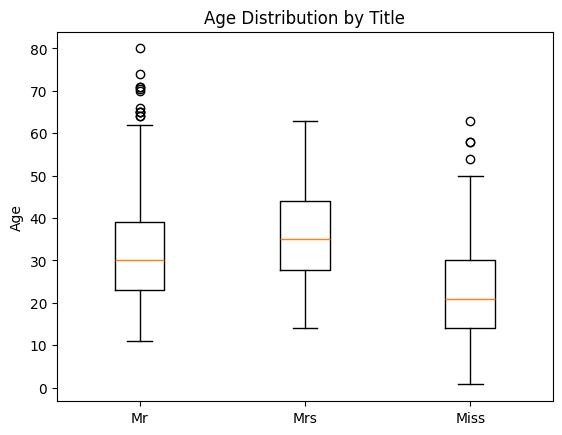

In [16]:
import matplotlib.pyplot as plt

mr_age = df_train[df_train['Name'].str.contains('Mr\.', na=False)]
mr_age = mr_age['Age'].dropna()
print(mr_age.describe())

mrs_age = df_train[df_train['Name'].str.contains('Mrs\.', na=False)]
mrs_age = mrs_age['Age'].dropna()
print(mrs_age.describe())

miss_age = df_train[df_train['Name'].str.contains('Miss\.', na=False)]
miss_age = miss_age['Age'].dropna()
print(miss_age.describe())

# 박스플롯 그리기
plt.boxplot([mr_age, mrs_age, miss_age])

# x축 눈금 이름 설정
plt.xticks([1, 2, 3], ['Mr', 'Mrs', 'Miss'])

# 제목과 축 레이블 설정 (선택 사항)
plt.title('Age Distribution by Title')
plt.ylabel('Age')

# 그래프 표시
plt.show()


Mr의 경우에는 이상치가 너무 많다.
그래도 그 나이를 계산하기가 너무 복잡하기 때문에 각자의 평균으로 결측치를 채우자


In [17]:
# Mr이름의 평균치로 결측치 채우기
mr_mask = df_train['Name'].str.contains('Mr\.', na=False)


# 그중에서 Age가 null인 행만 선택
# &연산자로 조건을 더해간다
mr_age_null = df_train[mr_mask & df_train['Age'].isnull()]

# Mr. 그룹의 평균 나이 계산
mr_age_mean = df_train[mr_mask]['Age'].mean().round(0)
print(mr_age_mean)

# Age가 null이고 mister로 마스킹된 행을 평균값으로 채우기
df_train.loc[mr_mask & df_train['Age'].isnull(), 'Age'] = mr_age_mean

32.0


In [18]:
# Mrs이름의 평균치로 결측치 채우기
mr_mask = df_train['Name'].str.contains('Mrs\.', na=False)


# 그중에서 Age가 null인 행만 선택
# &연산자로 조건을 더해간다
mr_age_null = df_train[mr_mask & df_train['Age'].isnull()]

# Mr. 그룹의 평균 나이 계산
mr_age_mean = df_train[mr_mask]['Age'].mean().round(0)
print(mr_age_mean)

# Age가 null이고 mister로 마스킹된 행을 평균값으로 채우기
df_train.loc[mr_mask & df_train['Age'].isnull(), 'Age'] = mr_age_mean

36.0


In [19]:
# Miss이름의 평균치로 결측치 채우기
mr_mask = df_train['Name'].str.contains('Miss\.', na=False)


# 그중에서 Age가 null인 행만 선택
# &연산자로 조건을 더해간다
mr_age_null = df_train[mr_mask & df_train['Age'].isnull()]

# Mr. 그룹의 평균 나이 계산
mr_age_mean = df_train[mr_mask]['Age'].mean().round(0)
print(mr_age_mean)

# Age가 null이고 mister로 마스킹된 행을 평균값으로 채우기
df_train.loc[mr_mask & df_train['Age'].isnull(), 'Age'] = mr_age_mean

22.0


In [20]:
# 어 이래도 결측치로 나이가 하나 남는다. 이 경우에는 신부나 기사와 같은 특수한 이름을 지닌 사람의 결측치이기에
# 알아보니 Dr란다. 즉 박사정도이니 나이를 Mr의 평균과 같게 설정해도 문제가 없을 것이다.
df_train[df_train['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_isna
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6,NaN,C,1


In [21]:
# Age에 남아있는 결측치를 Mr로 이름이 시작하는 사람들의 나이의 평균으로 설정
df_train['Age'] = df_train['Age'].fillna(df_train[df_train['Name'].str.contains('Mr\.', na=False)]['Age'].mean().round(0))


###Cabin
Cabin의 데이터를 살펴보고 결측치의 제거에 대해 고민해보자

In [22]:
df_train['Cabin'].head()

,Cabin
0,NaN
1,C85
2,NaN
3,C123
4,NaN


Cabin이라는 값이 null이 좀 있는데 그 유무가 생존률에 영향 가능이기에  
그래서 Cabin도 Cabin_isna라는 행을 추가해주자  
그 외에 Cabin의 값이 일관성이 없기에 가공에 무리가 있다 판단, 버리자

In [23]:
df_train['Cabin_is_na'] = df_train['Cabin'].isnull().astype(int)
# Cabin은 객실의 위치를 말하는 코드이다. 의미가 크게 없기에 해당 행을 버린다
df_train = df_train.drop(columns = ['Cabin'])

Embarked의 값에서 결측치가 존재하는데 2건밖에 없기에 대표값(가장 많이 쓰인 값)으로 대체한다

In [24]:
replae_embarked = df_train['Embarked'].value_counts().idxmax()
df_train['Embarked'] = df_train['Embarked'].fillna(replace_embarked)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_isna,Cabin_is_na
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,1


In [25]:
df_train.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


결측치가 전부 사라진 것을 확인할 있다,

###이상치 제거
이상치를 제거하기 위해 여러 방법을 써보자

In [26]:
#먼저 이상치가 있을만한 데이터가 있는지 하나씩 확인해야 한다
df_train['Pclass'].value_counts().sort_index()

,count
Pclass,
1,216
2,184
3,491


In [27]:
df_train['Sex'].value_counts().sort_index()

,count
Sex,
female,314
male,577


In [28]:
df_train['Sex'].value_counts().sort_index()

,count
Sex,
female,314
male,577


In [29]:
df_train['Parch'].value_counts().sort_index()

,count
Parch,
0,678
1,118
2,80
3,5
4,4
5,5
6,1


In [30]:
df_train['Age']

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
...,...
886,27.0
887,19.0
888,22.0
889,26.0


In [31]:
df_train['Fare']

,Fare
0,7.2500
1,71.2833
2,7.9250
3,53.1000
4,8.0500
...,...
886,13.0000
887,30.0000
888,23.4500
889,30.0000


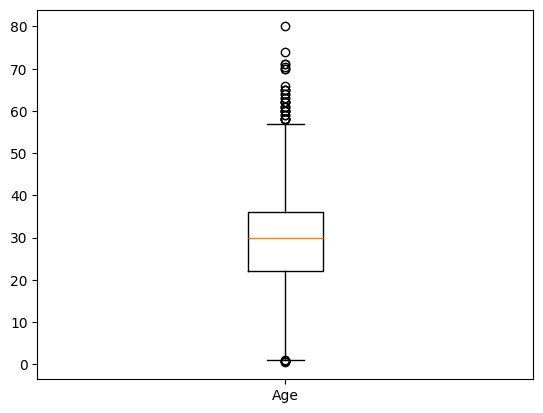

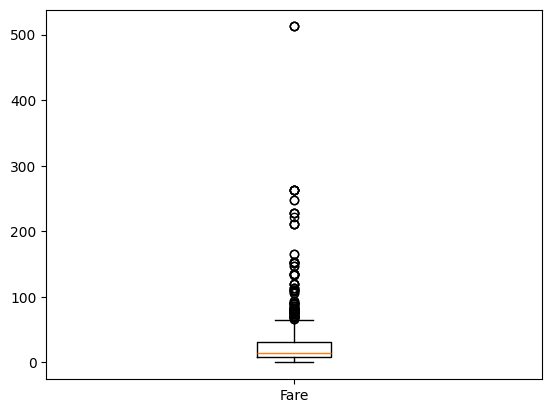

In [32]:
#위의 값들에 이상치가 있는지 확인하는 코드이다.
#확인 가능한 값이 가격과 나이라서, 이를 matplotlib의 boxplot으로 그려보자

import matplotlib.pyplot as plt

plt.boxplot([df_train['Age']])
plt.xticks([1],['Age'])
plt.show()

plt.boxplot([df_train['Fare']])
plt.xticks([1],['Fare'])
plt.show()

이상치란 "잘못 기입되었을 가능성이 있는 값"인데 Fare의 500불 정도의 호실 가격이 보인다.

당시에도 초초초초스위츠룸이 있었을 것이기 때문에 말이 안되지는 않지만,   
가격이 너무 나머지와 동떨어져있어서 이 이상치를 제외한 최대값으로 설정하자   
이유는 학습에 영향이 갈 수 있어서이다.

In [33]:
#가장 높이 떠있는
df_train['Fare'].sort_values(ascending=False)

,Fare
679,512.3292
258,512.3292
737,512.3292
88,263.0000
438,263.0000
...,...
806,0.0000
815,0.0000
466,0.0000
481,0.0000


In [34]:
# Fare가 500 이상인 값만 263(최대값은 아니나 그다음 가장 높은 값)으로 대체
df_train.loc[df_train['Fare'] >= 500, 'Fare'] = 263.0
df_train['Fare'].sort_values(ascending = False)

,Fare
438,263.0
341,263.0
27,263.0
679,263.0
258,263.0
...,...
806,0.0
815,0.0
466,0.0
481,0.0


이로서 이상치를 전부 제거했다 보면 될것이다.

### 정규화

정규화를 하는 이유는 인공지능이 더 학습을 잘 할 수 있게 하기 위해서인데,   
값의 범위가 너무 크면(Fare의 경우 260정도까지 범위가 커지니)  
"경사하강법"을 기반으로 하는 모델학습의 학습 방향이 비효율적이게 될 가능성이 있다.  
특성간의 스케일을 맞춰서 인공지능의 판단이 왜곡될 가능성을 줄이기도 한다.


In [35]:
from sklearn import preprocessing

columns_to_scale = ['Age', 'Fare']
#age, fare에 대해 z-score 정규화====> 스탠다드 스케일러를 썼다고 판단해야 한다
#예를들어 MinMaxScaler가 있는데 이 경우에는 0~1 사이로 정규화 하는 것이다.
scaler_train = preprocessing.StandardScaler()
scaler_train = scaler_train.fit(df_train[columns_to_scale])
#나이와 금액의 평균과 표준편차를 구한다.
df_train[columns_to_scale] = scaler_train.transform(df_train[columns_to_scale])
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_isna,Cabin_is_na
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.581839,1,0,A/5 21171,-0.557777,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.626038,1,0,PC 17599,0.923322,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.279870,0,0,STON/O2. 3101282,-0.542164,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.399561,1,0,113803,0.502740,S,0,0
4,5,0,3,"Allen, Mr. William Henry",male,0.399561,0,0,373450,-0.539272,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,-0.204377,0,0,211536,-0.424778,S,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,-0.808316,0,0,112053,-0.031566,S,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.581839,1,2,W./C. 6607,-0.183068,S,1,1
889,890,1,1,"Behr, Mr. Karl Howell",male,-0.279870,0,0,111369,-0.031566,C,0,0


Age와 Fare가 StandardScaler로 표준정규화가 되었고, 따라서 평균인 0을 기준으로 값이 분포된다.

In [36]:
#데이터셋 임시 저장
df_train2 = df_train
df_train2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_isna,Cabin_is_na
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.581839,1,0,A/5 21171,-0.557777,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.626038,1,0,PC 17599,0.923322,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.279870,0,0,STON/O2. 3101282,-0.542164,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.399561,1,0,113803,0.502740,S,0,0
4,5,0,3,"Allen, Mr. William Henry",male,0.399561,0,0,373450,-0.539272,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,-0.204377,0,0,211536,-0.424778,S,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,-0.808316,0,0,112053,-0.031566,S,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-0.581839,1,2,W./C. 6607,-0.183068,S,1,1
889,890,1,1,"Behr, Mr. Karl Howell",male,-0.279870,0,0,111369,-0.031566,C,0,0


### 인코딩

인코딩이란 값의 형식을 바꾸는 것을 말하는데, 여기서 우리는   
sex와 embarked의 값이 문자열로 되어있으니, 이를 bool형태나 숫자형태로 바꿔서   
학습의 효율성을 높여줄 수 있다.

In [37]:
#df_train = pd.get_dummies(df_train, columns = ['Sex', 'Embarked'])
#df_train.iloc[:, -5:]   iloc는 index에 대한 슬라이싱, 이 경우 뒤에서 5개(-5)행을 출력한다
df_train.loc[df_train['Sex'] == 'female', 'Sex'] = 0.0
df_train.loc[df_train['Sex'] == 'male', 'Sex'] = 1.0


#sex가 male, female에 따라 갑싱 0과 1로 구분되었다



df_train.loc[df_train['Embarked'] == 'S', 'Embarked'] = 1.0
df_train.loc[df_train['Embarked'] == 'C', 'Embarked'] = 0.0
df_train.loc[df_train['Embarked'] == 'Q', 'Embarked'] = -1.0
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_isna,Cabin_is_na
0,1,0,3,"Braund, Mr. Owen Harris",1.0,-0.581839,1,0,A/5 21171,-0.557777,1.0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,0.626038,1,0,PC 17599,0.923322,0.0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0.0,-0.279870,0,0,STON/O2. 3101282,-0.542164,1.0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,0.399561,1,0,113803,0.502740,1.0,0,0
4,5,0,3,"Allen, Mr. William Henry",1.0,0.399561,0,0,373450,-0.539272,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1.0,-0.204377,0,0,211536,-0.424778,1.0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",0.0,-0.808316,0,0,112053,-0.031566,1.0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0.0,-0.581839,1,2,W./C. 6607,-0.183068,1.0,1,1
889,890,1,1,"Behr, Mr. Karl Howell",1.0,-0.279870,0,0,111369,-0.031566,0.0,0,0


### 생존률과 연관있을만한 컬럼 고안 및 생성



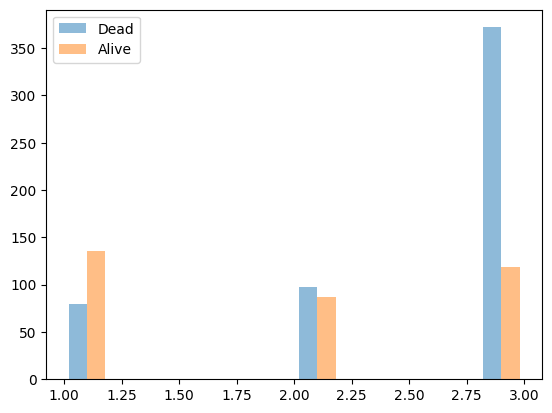

In [38]:
# Pclass에 따른 Survived(사망자/생존자) 분포
hist1 = df_train[df_train['Survived']==0]['Pclass']
hist2 = df_train[df_train['Survived']==1]['Pclass']
plt.hist([hist1, hist2], label=['Dead', 'Alive'], alpha=0.5)
plt.legend(loc=0)

확실히 3등칸의 사망률이 압도적으로 높고, 1등칸에 가까울수록 그 생존률이 올라감을 확인할 수 있다.

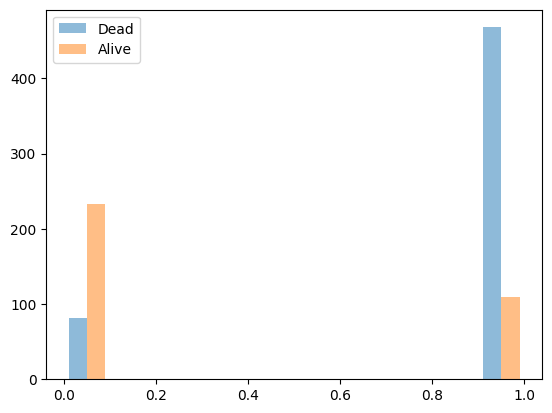

In [39]:
# Sex에 따른 Survived(사망자/생존자) 분포
hist1 = df_train[(df_train['Survived']==0)]['Sex']
hist2 = df_train[(df_train['Survived']==1)]['Sex']
plt.hist([hist1,hist2], label=['Dead','Alive'], alpha=0.5)
plt.legend(loc=0)

0이 여자, 1이 남자로 설정되었기 때문에 남녀차이에 따른 생존률 확인 가능

([<matplotlib.axis.YTick at 0x7f1a91e91150>,
 [Text(0, 0.5, 'Pclass'),
  Text(0, 1.5, 'Age'),
  Text(0, 2.5, 'SibSp'),
  Text(0, 3.5, 'Parch'),
  Text(0, 4.5, 'Fare'),
  Text(0, 5.5, 'Age_isna'),
  Text(0, 6.5, 'Survived'),
  Text(0, 7.5, 'Cabin_is_na')])

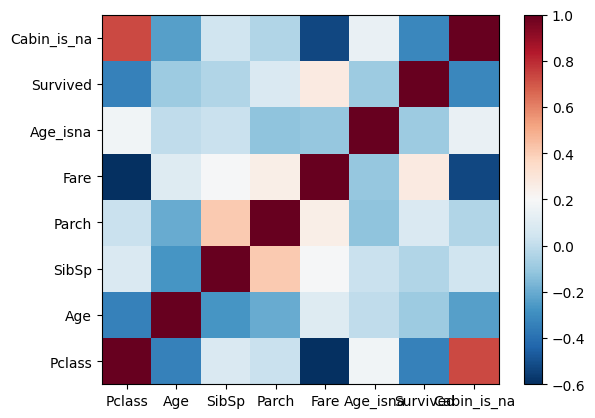

In [40]:
import numpy as np

# 상관관계 시각화
cols_to_corr = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare','Age_isna','Survived','Cabin_is_na']
fig, ax = plt.subplots(1, 1)
c = ax.pcolor(df_train[cols_to_corr].corr().round(2), cmap='RdBu_r')
fig.colorbar(c, ax=ax)
plt.xticks(np.arange(0.5, len(cols_to_corr), 1), cols_to_corr)
plt.yticks(np.arange(0.5, len(cols_to_corr), 1), cols_to_corr)

상관관계를 표로 표로 그려보니 생존률과 관련이 제일 큰것은 pClass, 즉 객실등급이다.  
객실 등급이 높아지면 객실이 높은 위치에 있으니 탈출하기 쉬웠을 것이다.

두번째로 cabin, 즉 호실번호가 null인 값들이 있었는데   
이들은 pclass와 큰 연관성을 띄고(호실등급이 낮으면 cabin이름 측정 어려움?)  
생존률과 역의 상관관계를 보여준다.

In [41]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_isna,Cabin_is_na
0,1,0,3,"Braund, Mr. Owen Harris",1.0,-0.581839,1,0,A/5 21171,-0.557777,1.0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,0.626038,1,0,PC 17599,0.923322,0.0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0.0,-0.279870,0,0,STON/O2. 3101282,-0.542164,1.0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,0.399561,1,0,113803,0.502740,1.0,0,0
4,5,0,3,"Allen, Mr. William Henry",1.0,0.399561,0,0,373450,-0.539272,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1.0,-0.204377,0,0,211536,-0.424778,1.0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",0.0,-0.808316,0,0,112053,-0.031566,1.0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0.0,-0.581839,1,2,W./C. 6607,-0.183068,1.0,1,1
889,890,1,1,"Behr, Mr. Karl Howell",1.0,-0.279870,0,0,111369,-0.031566,0.0,0,0


In [62]:
def fill_missing_age_by_title(df, title='Miss'):
    """
    특정 타이틀을 가진 승객의 Age 결측치를 해당 그룹의 평균으로 채우는 함수

    Parameters:
        df (pd.DataFrame): 타이타닉 원본 데이터프레임
        title (str): 기준이 되는 타이틀. 예: 'Mr', 'Mrs', 'Miss', 'Master', etc.

    Returns:
        pd.DataFrame: Age 결측치가 보완된 데이터프레임
    """
    # 타이틀 기반 마스킹
    title_pattern = rf"{title}\."
    title_mask = df['Name'].str.contains(title_pattern, na=False)

    # 해당 그룹의 평균 나이
    title_age_mean = df[title_mask]['Age'].mean().round(0)

    # Age가 결측치인 행에 평균 나이 채우기
    df.loc[title_mask & df['Age'].isnull(), 'Age'] = title_age_mean

    return df


In [63]:
# 전체 전처리 과정 함수화
def temp_preprocessing(df_orig, mode='train', replace_embarked = None, scaler = None):
  df = df_orig.copy()
  if mode == 'train':
    replace_embarked = df['Embarked'].value_counts(dropna=False).idxmax()
  df['Embarked'] = df['Embarked'].fillna(replace_embarked)
  df['Age_isna'] = df['Age'].isna().astype(int)
  fill_missing_age_by_title(df, title='Miss')
  fill_missing_age_by_title(df, title='Master')
  fill_missing_age_by_title(df, title='Mr')
  df['Age'] = df['Age'].fillna(df[df['Name'].str.contains('Mr\.', na=False)]['Age'].mean().round(0))



  if mode == 'train':
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(df[['Age','Fare']])
  df[['Age','Fare']] = scaler.transform(df[['Age','Fare']])

  #df_train = pd.get_dummies(df_train, columns = ['Sex', 'Embarked'])
  #df_train.iloc[:, -5:]   iloc는 index에 대한 슬라이싱, 이 경우 뒤에서 5개(-5)행을 출력한다
  df.loc[df['Sex'] == 'female', 'Sex'] = 0.0
  df.loc[df['Sex'] == 'male', 'Sex'] = 1.0
  df['Sex'] = df['Sex'].astype(int)



  #sex가 male, female에 따라 갑싱 0과 1로 구분되었다



  df.loc[df['Embarked'] == 'S', 'Embarked'] = 1.0
  df.loc[df['Embarked'] == 'C', 'Embarked'] = 0.0
  df.loc[df['Embarked'] == 'Q', 'Embarked'] = -1.0
  df['Embarked'] = df['Embarked'].astype(int)

  #특수 이름 가진 사람들에 대한 컬럼 추가
  df['Name_has_title'] = df['Name'].str.contains('Master|Dr|Rev|Major|Col|Capt|Jonkheer|Don|Countess|Sir').astype(int)

  # 학습에 방해가 될 컬럼들 제거(위에서 활용할만큼 다 씀)
  df = df.drop(columns=['Name', 'Ticket', 'Cabin'])

  return df, replace_embarked, scaler


##훈련용 데이터 전처리
교육용 데이터들을 다 정제했기 때문에 이제는 훈련용 데이터를 전처리할 시간이다.

In [64]:
# Feature(X)와 Label(y)를 찾아야 한다,
# 여기서 Feature는 모델이 학습 시 입력으로 사용하는 변수
# Label은 모델이 예측하려고 하는 정답 또는 결과 값
df_train = pd.read_csv(colab_path + '/titanic_train.csv')
df_train, replace_embarked, scaler = temp_preprocessing(df_train,'train')


#Feature(X), Label(y) 분리
target_col = ['Survived','PassengerId']
y = df_train[target_col]
y = y.set_index('PassengerId')
X = df_train.drop(columns=[target_col[0]])
X = X.set_index('PassengerId')

In [65]:
# 숫자만 보이는 아주 훌륭한 데이터셋이 되었다.
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_isna,Name_has_title
PassengerId,,,,,,,,,
1,3,1,-0.577165,1,0,-0.502445,1,0,0
2,1,0,0.632993,1,0,0.786845,0,0,0
3,3,0,-0.274626,0,0,-0.488854,1,0,0
4,1,0,0.406088,1,0,0.420730,1,0,0
5,3,1,0.406088,0,0,-0.486337,1,0,0
...,...,...,...,...,...,...,...,...,...
887,2,1,-0.198991,0,0,-0.386671,1,0,1
888,1,0,-0.804070,0,0,-0.044381,1,0,0
889,3,0,-0.577165,1,2,-0.176263,1,1,0


## 모델 불러오기
Logistic Regression, SVC, RandomForestClassifier의 모델을 불러오도록 하자

In [66]:
from sklearn.model_selection import train_test_split

#여기서 train_X는 학습용 입력 데이터, val_X는 검증용 입력 데이터
#train_y는 학습용 타깃(label=정답) 데이터, val_y는 검증용 타깃 데이터
# train으로 모델을 학습시키고, val로 성능을 검증하는 방식이다.

#코드를 보면 test_size = 0.3인데 전체 데이터의 30퍼를 검증용으로 사용한단 말이다
# 그 30퍼의 데이터는 42라는 시드값으로 랜덤하게 선정한다.
train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=0.3, random_state=42)

In [67]:
#모델 학습 ==> Logistic Regression
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(C=20, max_iter=1000, random_state=42)
model1.fit(train_X, train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=20, max_iter=1000, random_state=42)

In [68]:
# 모델 학습 ==> SVC(support vector classifier)
from sklearn.svm import SVC
model2 = SVC(kernel = 'linear', probability=True, random_state=42)
model2.fit(train_X, train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear', probability=True, random_state=42)

In [69]:
# 모델 학습 ==> RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier(n_estimators=100, random_state=42)
# model3 = RandomForestClassifier(n_estimators=8, max_depth = 3, random_state=42)
model3.fit(train_X, train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [71]:
# 모델 학습 ==> XGBClassifier
# gradient boosting 알고리즘을 더 빠르고 효율적으로 만든 라이브러리
from xgboost import XGBClassifier

# model4 = XGBClassifier(n_estimators=8, max_depth = 3, random_state=42)
model4 = XGBClassifier(n_estimators=100, random_state=42)
model4.fit(train_X, train_y)

#오류 해결===> 내부 데이터값이 object여서 에러가 나길래
# df_train['Fare'] = df_train['Fare'].astype(int) 이런 형식으로 int로 변환

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [72]:
# Logistic Regression모델 평가
print(model1.score(train_X, train_y))  # accuracy
print(model1.score(val_X, val_y))

0.8138041733547352
0.7985074626865671


In [73]:
#SVM 모델 평가
print(model2.score(train_X, train_y))  # accuracy
print(model2.score(val_X, val_y))

0.7961476725521669
0.7947761194029851


In [74]:
# Random Forest모델 평가
print(model3.score(train_X, train_y))  # accuracy
print(model3.score(val_X, val_y))

0.9823434991974318
0.8059701492537313


In [75]:
# XGBoost 모델 평가
print(model4.score(train_X, train_y))  # accuracy
print(model4.score(val_X, val_y))

0.9743178170144462
0.7798507462686567


In [77]:
# AUC Score
# Area Under Curve이며, 모델이 얼마나 잘 클래스를 구분하는지 나타내는 점수이다.

from sklearn.metrics import roc_auc_score
print('AUC value (Logistic Regression): {}'.format(roc_auc_score(val_y, model1.predict(val_X))))
print('AUC value (SVM): {}'.format(roc_auc_score(val_y, model2.predict(val_X))))
print('AUC value (RandomForest): {}'.format(roc_auc_score(val_y, model3.predict(val_X))))
print('AUC value (XGBoost): {}'.format(roc_auc_score(val_y, model4.predict(val_X))))

AUC value (Logistic Regression): 0.7923911172318816
AUC value (SVM): 0.7826074482125438
AUC value (RandomForest): 0.7961209617260573
AUC value (XGBoost): 0.7711883858380674


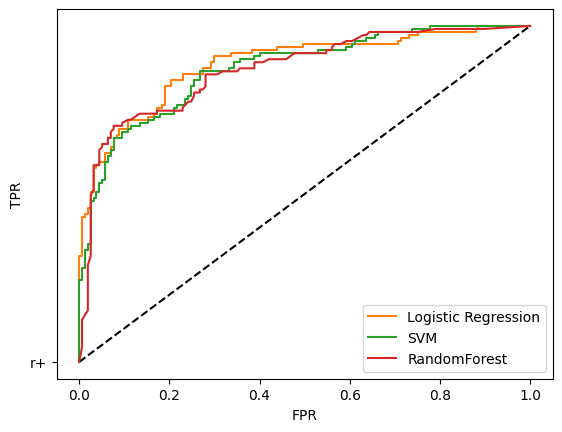

In [78]:
# ROC Curve 플롯팅
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(val_y, model1.predict_proba(val_X)[:,1])
plt.plot([0,1], [0,1], "k--", "r+") #0.5 기준선
plt.plot(fpr, tpr, label='Logistic Regression')
fpr2, tpr2, thresholds2 = roc_curve(val_y, model2.predict_proba(val_X)[:,1])
plt.plot(fpr2, tpr2, label='SVM')
fpr3, tpr3, thresholds3 = roc_curve(val_y, model3.predict_proba(val_X)[:,1])
plt.plot(fpr3, tpr3, label='RandomForest')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=0)

가장 좌측으로 배가 튀어나논 그래프가 가장 성능 좋은 그래프라 할 수 있다 .   
여기서 TPR은 민감도(모델이 양성이라 예측한 비율),    
FPR은 위양성률(모델이 틀리게 양성이라 예측한 비율)

In [81]:
import pickle
#모델 저잘

with open(colab_path +'/saved_model2.pickle','wb') as fw:
  pickle.dump(model1, fw)

In [82]:
with open(colab_path + '/saved_model1.pickle','rb') as  f:
  logicModel = pickle.load(f)

In [83]:
# 모델 평가
print(logicModel.score(train_X, train_y))  # accuracy
print(logicModel.score(val_X, val_y))

0.8138041733547352
0.7985074626865671


## 최종 제출용 데이터 예측

In [84]:
# 테스트 데이터 전처리
df_test = pd.read_csv(colab_path + '/titanic_test.csv')
df_test, replace_embarked, scaler = temp_preprocessing(df_test, 'test', replace_embarked, scaler)
df_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_isna,Name_has_title
0,892,3,1,0.368271,0,0,-0.490783,-1,0,0
1,893,3,0,1.313707,1,0,-0.507479,1,0,0
2,894,2,1,2.448230,0,0,-0.453367,-1,0,0
3,895,3,1,-0.198991,0,0,-0.474005,1,0,0
4,896,3,0,-0.577165,1,1,-0.401017,1,0,0
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,1,0.179183,0,0,-0.486337,1,1,0
414,1306,1,0,0.708628,0,0,1.544246,0,0,1
415,1307,3,1,0.670810,0,0,-0.502445,1,0,0
416,1308,3,1,0.179183,0,0,-0.486337,1,1,0


survived가 사라진 검증용 데이터임을 확인

In [86]:
#결측치 처리
test_y = pd.read_csv(colab_path + '/titanic_gender_submission.csv')

test_y = test_y['Survived']

replace_fare = df_train['Fare'].mean().round(2)
df_test['Fare'] = df_test['Fare'].fillna(replace_fare)
test_X = df_test.set_index('PassengerId')

In [89]:
print(logicModel.score(test_X, test_y))

0.9449760765550239


In [87]:
pred_y = logicModel.predict(test_X)
df_pred_y = pd.DataFrame(pred_y, columns=['Survived'])
df_pred_y['PassengerId'] = df_test['PassengerId']
df_pred_y = df_pred_y.set_index('PassengerId')
df_pred_y.to_csv(colab_path + '/my_submission.csv')

In [90]:
# 최종 생존율 예측
pred_y = logicModel.predict(test_X)
df_result = pd.DataFrame({'PassengerId':df_test['PassengerId'], 'Survived': pred_y})
df_pred_y.to_csv(colab_path + '/my_submission3.csv')

## 후기
기존 데이터의 경우보다 Logistic Regression은 1퍼 정확도가 상승했으나
오히려 나머지 모델의 경우 Accuracy 가 더 떨어진 것을 확인하였다.

이번 변형은 최대한 Column의 수를 줄이려 했던 것이 내 방법론이였는데
Logistic Regression은 이 방법이 조금은 도움이 되었고,

SVC, RandomForest, XGBoost의 경우에는 column의 갯수가 많은 편이 학습에 더 좋은 영향을 끼침을 알 수 있었다.   


물론 그 상승, 하락치가 기존에 비해 미비해서 이를 신뢰할 수 있단것은 아니다.  
하지만 kisia에서 진행하는 ai 개발 악성코드반에서 배운 내용의복습과 이해 면에서는 많은 도움이 되었다는 것으로 글을 마친다